## CLUSTERING

Cargamos el modelo desde un pickle para no perder los tipos de datos de las columnas, puesto que con csv los perderiamos

In [1]:
import polars as pl
import pickle


with open("datos_grouped(clustering).pkl", "rb") as file:
    df = pickle.load(file)


df


CustomerID,Last_buy,Frequency,Monetary,Monetary_log,Frequency_log,Last_buy_scaled,Frequency_scaled,Monetary_scaled
i64,f64,u32,f64,f64,f64,f64,f64,f64
17179,178.0,3,701.84,6.555129,1.386294,0.86105,0.099487,0.310608
16125,367.0,1,273.45,5.614769,0.693147,2.752417,-0.948408,-0.443281
18227,217.0,1,30.0,3.433987,0.693147,1.251332,-0.948408,-2.191619
15607,336.0,1,87.76,4.485936,0.693147,2.442193,-0.948408,-1.348269
17712,44.0,1,403.21,6.001935,0.693147,-0.479919,-0.948408,-0.132889
…,…,…,…,…,…,…,…,…
14806,75.0,1,66.0,4.204693,0.693147,-0.169695,-0.948408,-1.573742
13883,10.0,5,2176.33,7.685855,1.791759,-0.820165,0.712467,1.217113
15589,255.0,3,413.73,6.027628,1.386294,1.631607,0.099487,-0.112291


El primer modelo que vamos a aplicar es el dbscan

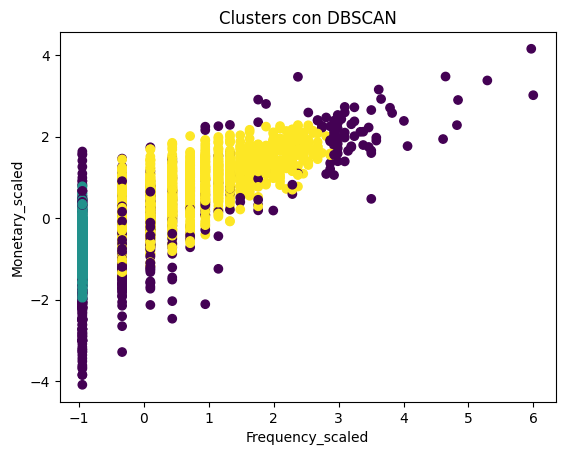

In [2]:
from sklearn.cluster import DBSCAN



X = df[['Last_buy_scaled', 'Frequency_scaled', 'Monetary_scaled']]


dbscan = DBSCAN(eps=0.5, min_samples=100)
clusters = dbscan.fit_predict(X)


df = df.with_columns(
    pl.Series('Cluster', clusters)
)
import matplotlib.pyplot as plt

plt.scatter(df['Frequency_scaled'], df['Monetary_scaled'], c=df['Cluster'])
plt.xlabel('Frequency_scaled')
plt.ylabel('Monetary_scaled')
plt.title('Clusters con DBSCAN')
plt.show()


como hemos tenido solo dos clusteres y mucho ruido, vamos a intentar calcular mediante el vecino mas cercano el eps correcto

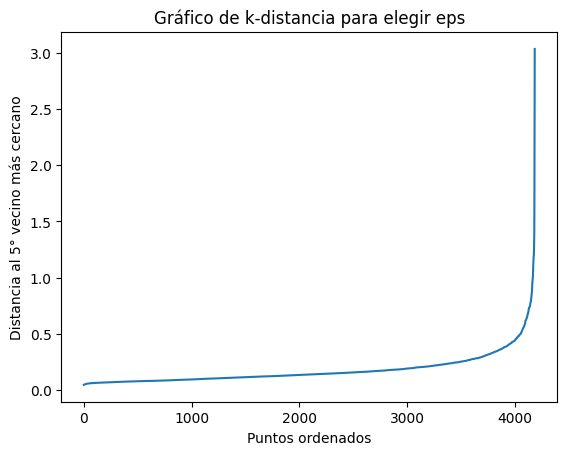

In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 9])
plt.plot(distances)
plt.ylabel('Distancia al 5° vecino más cercano')
plt.xlabel('Puntos ordenados')
plt.title('Gráfico de k-distancia para elegir eps')
plt.show()


como vemos, el codo empezaria aproximadamente entre el 0.38 y el 0.5, vamos a probar diferentes valores

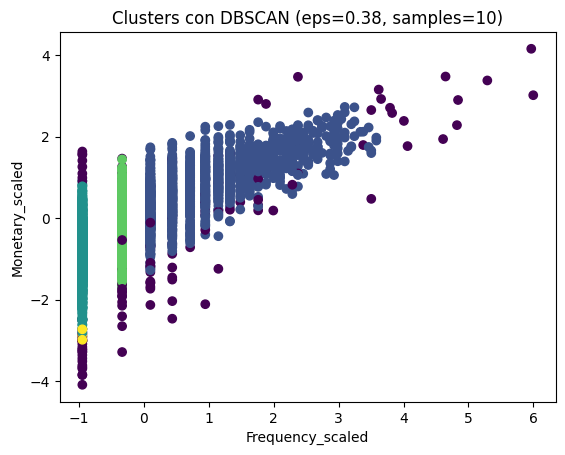

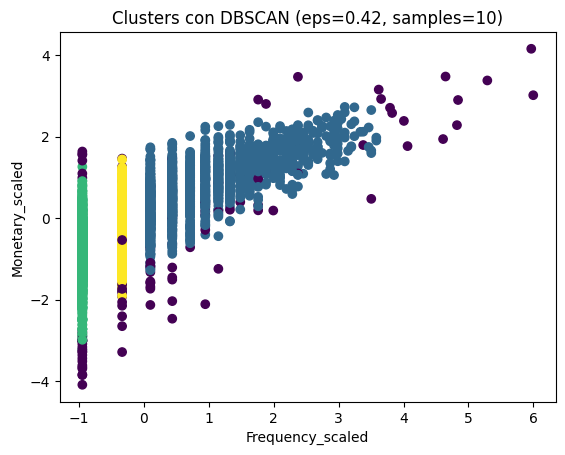

In [6]:
for eps in [0.38, 0.42]:
    min_samples = 10
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    df = df.with_columns(
    pl.Series('Cluster', clusters)
)

    plt.scatter(df['Frequency_scaled'], df['Monetary_scaled'], c=df['Cluster'])
    plt.xlabel('Frequency_scaled')
    plt.ylabel('Monetary_scaled')
    plt.title(f'Clusters con DBSCAN (eps={eps}, samples={min_samples})')
    plt.show()


nos quedaremos con eps 0.42 y 10 samples dado que tiene menos ruido que 0.38 y parece que define mejor los subgrupos

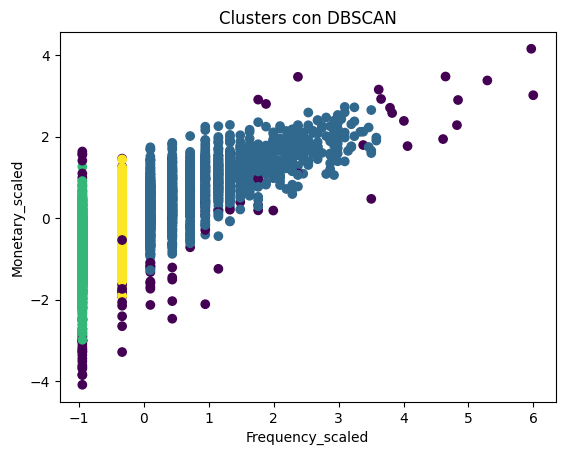

In [76]:
dbscan = DBSCAN(eps=0.42, min_samples=10)
clusters = dbscan.fit_predict(X)


df = df.with_columns(
    pl.Series('Cluster', clusters)
)
import matplotlib.pyplot as plt

plt.scatter(df['Frequency_scaled'], df['Monetary_scaled'], c=df['Cluster'])
plt.xlabel('Frequency_scaled')
plt.ylabel('Monetary_scaled')
plt.title('Clusters con DBSCAN')
plt.show()

Ahora que tenemos claro que la combinacion mas adecuada, eps0.42 y samples a 10, vamos a proceder a analizar las caracteristicas de los clientes

In [77]:
df.group_by('Cluster').mean()


Cluster,CustomerID,Last_buy,Frequency,Monetary,Monetary_log,Frequency_log,Last_buy_scaled,Frequency_scaled,Monetary_scaled
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1,15392.309735,155.876106,14.168142,3803.04992,5.664303,1.78209,0.639651,0.697848,-0.40357
1,15272.863014,154.417123,1.0,235.39485,5.168557,0.693147,0.625051,-0.948408,-0.80101
0,15305.027473,38.557143,6.690659,1730.007573,7.103454,1.891873,-0.534387,0.863818,0.750201
2,15284.144836,90.413098,2.0,472.647078,5.931596,1.098612,-0.015453,-0.335428,-0.18928


Como vemos se divide en tres grupos principales:

cluster 0 =  que hace compras muy a menudo y de alto valos monetario, y ademas no tarda mucho en volver a comprar
cluster 1 = que hace pocas compras cada mucho tiempo y por poco dinero
cluster 2 = hace mas compras que el cluster 0 pero menos que el cluster 1, es decir seria lo intermedio.

Viendo esto podriamos hacer ofertas exclusivas a por ejemplo el grupo 2 para motivar que compren o al grupo 0 teniendo en cuenta que son mas propensos a comprar.

In [78]:
df['Cluster'].value_counts()


Cluster,count
i64,u32
0,1820
2,794
1,1460
-1,113


contando la cantidad de clientes, nos damos cuenta que los mas habituales son los que compran mucho, y tenemos el -1 que podriamos entender como un grupo vip

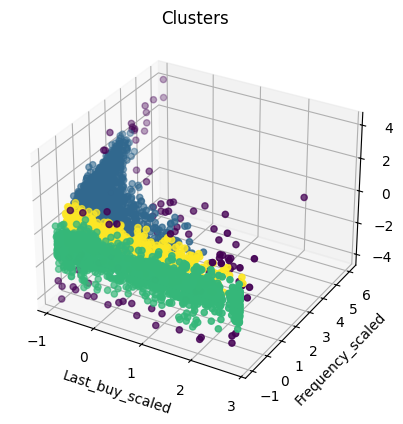

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Last_buy_scaled'], df['Frequency_scaled'], df['Monetary_scaled'], c=df['Cluster'])
ax.set_xlabel('Last_buy_scaled')
ax.set_ylabel('Frequency_scaled')
ax.set_zlabel('Monetary_scaled')
plt.title('Clusters')
plt.show()


Leemos el archivo CSV y seleccionamos las columnas que vamos a usar. En este caso, utilizaremos las columnas Frequency, Monetory y LastBuy, ya que están escaladas, por lo que no es necesario hacer un preprocesamiento adicional.

Dado que en DBSCAN se requieren los valores de Epsilon y Min Samples, y el resultado depende de los valores que elijamos, creamos un conjunto de combinaciones de estos parámetros para probar y encontrar la mejor configuración.

Para esta combinación, hemos establecido que los valores de Epsilon varíen desde 0.01 hasta 1, divididos en 25 intervalos con separación igual. Luego, para Min Samples, hemos configurado que los valores vayan desde 2 hasta 30, con saltos de 2.

In [80]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as ss
import plotly.express as px
import itertools


df = pd.read_csv("https://raw.githubusercontent.com/Thepelican18/Master_AI_group_activity_1/refs/heads/moise/data_cleaned(clustering).csv")
mon_freq_buy = df[["Frequency_scaled", "Monetary_scaled", "Last_buy_scaled"]]
x = mon_freq_buy.to_numpy()
epsilons = np.linspace(0.01,1,num=25)
min_samples = np.arange(2,30,step = 2)
combinations = list(itertools.product(epsilons,min_samples))
N = len(combinations)
combinations

[(np.float64(0.01), np.int64(2)),
 (np.float64(0.01), np.int64(4)),
 (np.float64(0.01), np.int64(6)),
 (np.float64(0.01), np.int64(8)),
 (np.float64(0.01), np.int64(10)),
 (np.float64(0.01), np.int64(12)),
 (np.float64(0.01), np.int64(14)),
 (np.float64(0.01), np.int64(16)),
 (np.float64(0.01), np.int64(18)),
 (np.float64(0.01), np.int64(20)),
 (np.float64(0.01), np.int64(22)),
 (np.float64(0.01), np.int64(24)),
 (np.float64(0.01), np.int64(26)),
 (np.float64(0.01), np.int64(28)),
 (np.float64(0.051250000000000004), np.int64(2)),
 (np.float64(0.051250000000000004), np.int64(4)),
 (np.float64(0.051250000000000004), np.int64(6)),
 (np.float64(0.051250000000000004), np.int64(8)),
 (np.float64(0.051250000000000004), np.int64(10)),
 (np.float64(0.051250000000000004), np.int64(12)),
 (np.float64(0.051250000000000004), np.int64(14)),
 (np.float64(0.051250000000000004), np.int64(16)),
 (np.float64(0.051250000000000004), np.int64(18)),
 (np.float64(0.051250000000000004), np.int64(20)),
 (np.flo

Ahora creamos una función que itere entre estas combinaciones y busque la combinación que tenga el Silhouette Score más alto.

Esta función, dentro de un bucle, toma cada combinación de parámetros y la aplica al modelo DBSCAN. Luego, filtra los resultados basándose en la cantidad de clusters, excluyendo el cluster de noise (-1). El filtro se aplica si el número de clusters es mayor que 2 o menor de 10. Finalmente, la función selecciona la combinación con el mejor resultado y la devuelve como un diccionario.

In [ ]:
def get_score_and_labels(combinations,x):
    scores = []
    all_labels = []
    for i,(eps,num_samples) in enumerate(combinations):
        dbscan_cluster_model = DBSCAN(eps=eps,min_samples=num_samples).fit(x)
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusteres = len(labels_set)
        if -1 in labels_set:
            num_clusteres -=1
        if(num_clusteres < 3) or (num_clusteres > 10):
            scores.append(-10)
            all_labels.append("bad")
            c = (eps, num_samples)
            print(f"Combination {c} on iteration {i + 1} of {N} has {num_clusteres} clusters. Moving on")
            continue

        scores.append(ss(x,labels))
        all_labels.append(labels)
        print(f"Index: {i}, Score: {scores[-1]}, NumClusters: {num_clusteres}, Labels: {all_labels[-1]}")

    best_index = np.argmax(scores)
    best_params = combinations[best_index]
    best_labels = all_labels[best_index]
    best_score = scores[best_index]

    return {
        "best_epsilon":best_params[0],
        "best_min_samples":best_params[1],
        "best_labels":best_labels,
        "best_score":best_score,
    }
best_dict = get_score_and_labels(combinations,x)

Combination (np.float64(0.01), np.int64(2)) on iteration 1 of 350 has 102 clusters. Moving on
Combination (np.float64(0.01), np.int64(4)) on iteration 2 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(6)) on iteration 3 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(8)) on iteration 4 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(10)) on iteration 5 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(12)) on iteration 6 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(14)) on iteration 7 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(16)) on iteration 8 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(18)) on iteration 9 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(20)) on iteration 10 of 350 has 0 clusters. Moving on
Combination (np.float64(0.01), np.int64(22)) on iteration 11 of 350 has

Ahora podemos visualizar el resultado. Observamos que los datos se han dividido en solo 2 grupos, excluyendo los outliers. Además, el Silhouette Score es bastante bajo, con un valor de 0.26.

In [ ]:
df["Cluster"] = best_dict["best_labels"]
fig = px.scatter(x=df["Frequency"],y=df["Monetary"], color=df["Cluster"])
fig.show()
best_dict["best_score"]

# TODO

IDEAS PARA MEJORAR AQUI